In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def encode_labels(train, test, column):
    all_labels, _ = pd.concat([train[column], test[column]], axis=0).factorize(sort=True)
    
    train[column] = all_labels[:len(train)].astype(int)
    test[column] = all_labels[len(train):].astype(int)

def frequency_encode(train, test, columns):
    # Apparently this gives good results in lots of kaggle competitions
    # I couldn't find much online why the frequency is actually useful
    # as a feature. My intuition is that the model might match low or
    # high frequencies with card fraud in a case or another. Eg. if 
    # most of the frauds are coming from a certain email domain, the
    # frequency is going to be a useful feature.
    n = len(train) + len(test)
    for column in columns:
        f = (pd.concat(
                [train[column], test[column]], axis=0
            ).value_counts(dropna=True)/n).to_dict()    
        train[f"{column}_FE"] = train[column].map(f).astype(float)
        test[f"{column}_FE"] = test[column].map(f).astype(float)

def concatenate(train, test, col1, col2):
    new_name = f"{col1}_{col2}"
    train[new_name] = train[col1].astype(str)+ "_" + train[col2].astype(str)
    test[new_name] = test[col1].astype(str) + "_" + test[col2].astype(str)
    
    encode_labels(train, test, new_name)
    

def groupby(train, test, indexes, columns, aggregation):
    # We want for example, the mean transaction value for every card1_address1 pair
    for index in indexes:
        for column in columns:
            new_name = f"{column}_{index}_{aggregation}"

            f = pd.concat([train[[index, column]], test[[index, column]]])
            f = f.groupby([index])[column].agg(
                [aggregation]
            ).reset_index().rename(columns={aggregation: new_name})
            f.index = list(f[index])
            f = f[new_name].to_dict()
            train[new_name] = train[index].map(f).astype(float)
            test[new_name] = test[index].map(f).astype(float)
            train[new_name].fillna(-1, inplace=True)
            test[new_name].fillna(-1, inplace=True)

def groupby_unique(train, test, columns, card_id):
    # every card_id identifies a card
    # but generally a card_id does transactions only from a 
    # handful of email addresses, locations and details as 
    # such. So it's worth creating features that contain
    # the number of unique email addresses, addresses, distances, etc
    
    for column in columns:
        f = pd.concat([train[[card_id, column]], test[[card_id, column]]], axis=0)
        grouped = f.groupby(card_id)[column].agg(["nunique"])["nunique"].to_dict()
        train[f"{column}_{card_id}_count"] = train[card_id].map(grouped).astype("float32")
        test[f"{column}_{card_id}_count"] = test[card_id].map(grouped).astype("float32")


def factorize(train, test):    
    for column in test.columns:
        if str(train[column].dtype) not in {"category", "object"}:
            continue
        encode_labels(train, test, column)

In [2]:
X_train = pd.read_csv(
    "../ieee_fraud_data/train_transaction.csv", index_col="TransactionID")
X_test = pd.read_csv(
    "../ieee_fraud_data/test_transaction.csv", index_col="TransactionID")
test_identity = pd.read_csv(
    "../ieee_fraud_data/test_identity.csv", index_col="TransactionID")
train_identity = pd.read_csv(
    "../ieee_fraud_data/train_identity.csv", index_col="TransactionID")

In [3]:
X_train = X_train.merge(train_identity, how='left', left_index=True, right_index=True)
X_test = X_test.merge(test_identity, how='left', left_index=True, right_index=True)

# this does decref so GC can pick them up
# helps having more free ram and less swap on disk
# if potentially all the ram is used (although )
test_identity = None
train_identity = None

In [4]:
t1 = X_test.index
y_train = X_train["isFraud"].copy()
X_train = X_train.drop(columns=["isFraud"])
X_test.columns = X_train.columns

In [5]:
y_train.to_csv("y_train.csv")

In [6]:
for column in [
    "ProductCD", "card4", "card6", "R_emaildomain", "P_emaildomain",
    "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9",
    "id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", 
    "id_30", "id_31", "id_33", "id_34", "id_35", "id_36", "id_37", 
    "id_38", "DeviceType", "DeviceInfo"
]:
    X_train[column] = X_train[column].astype("category")
    X_test[column] = X_test[column].astype("category")
factorize(X_train, X_test)

In [7]:
### TransactionDT seems to be in seconds, we can transform to days
X_train["TDay"] = (X_train["TransactionDT"]/86400).astype(int)
X_test["TDay"] = (X_test["TransactionDT"]/86400).astype(int)

for i in [1, 2, 3, 4, 5, 10, 11]:
    X_train[f"D{i}"] = X_train["TDay"] - X_train[f"D{i}"]
    X_test[f"D{i}"] = X_test["TDay"] - X_test[f"D{i}"]

In [8]:
X_train[[f"D{i}" for i in range(1, 16)]].isna().sum()/len(X_train)
#D6, D7, D8, D9, D12, D13, D14 having > 50% of values NA, will drop them completely
X_train = X_train.drop(columns=["D6", "D7", "D8", "D9", "D12", "D13", "D14"])
X_test = X_test.drop(columns=["D6", "D7", "D8", "D9", "D12", "D13", "D14"])

In [9]:
# X_train.fillna(-9999,inplace=True)
# X_test.fillna(-9999, inplace=True)

In [10]:
## Splitting transaction amount into cents and whole value
## This might be a proxy for foreign currency, as generally
## fractional values are not that common in prices, but due
## to currency exchange prices it will become fractional
X_train["cents"] = (
    X_train["TransactionAmt"] - np.floor(X_train["TransactionAmt"])).astype("float32")
X_test["cents"] = (
    X_test["TransactionAmt"] - np.floor(X_test["TransactionAmt"])).astype("float32")

In [11]:
frequency_encode(X_train, X_test, ["addr1", "card1", "card2", "card3", "P_emaildomain"])
concatenate(X_train, X_test, "card1", "addr1")
concatenate(X_train, X_test, "card1_addr1", "P_emaildomain")
frequency_encode(X_train, X_test, ["card1_addr1", "card1_addr1_P_emaildomain"])
groupby(
    X_train, X_test,
    ["card1", "card1_addr1", "card1_addr1_P_emaildomain"],
    ["TransactionAmt", "D11"], "mean"
)
groupby(
    X_train, X_test,
    ["card1", "card1_addr1", "card1_addr1_P_emaildomain"],
    ["TransactionAmt", "D11"], "std"
)

In [12]:
### Define card identifier 
X_train["D1_rounded"] = np.floor(X_train["D1"]).astype("str")
X_test["D1_rounded"] = np.floor(X_test["D1"]).astype("str")
concatenate(X_train, X_test, "card1_addr1", "D1_rounded")
frequency_encode(X_train, X_test, ["card1_addr1_D1_rounded"])
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    ["TransactionAmt","D4", "D10", "D15"],
    "mean"
)
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    ["TransactionAmt","D4", "D10", "D15"],
    "std"
)
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    [f"C{i}" for i in range(1, 15)],
    "mean"
)
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    [f"M{i}" for i in range(1, 10)],
    "mean"
)

In [13]:
groupby_unique(
    X_train,
    X_test,
    ["P_emaildomain", "dist1", "cents", "id_02", "C13",
     "V127", "V136", "V309", "V307", "V314", "V320"],
    "card1_addr1_D1_rounded"
)

In [14]:
X_test = X_test.drop(columns=["card1_addr1_D1_rounded"])
X_train = X_train.drop(columns=["card1_addr1_D1_rounded"])

In [15]:
# X_train[X_train["P_emaildomain_card1_addr1_D1_count"] > 3][
#     [
#         "card1_addr1_D1", "card1", "P_emaildomain",
#         "P_emaildomain_card1_addr1_D1_count"]
#     ].sort_values(by=["card1_addr1_D1"])
# X_train[X_train["card1_addr1_D1"] == 82][
#     [
#         "card1_addr1_D1", "card1", "addr1", "P_emaildomain", 
#         "TransactionAmt", "P_emaildomain_card1_addr1_D1_count"]
#     ].sort_values(by=["card1_addr1_D1"])

In [16]:
# Define prediction folds
# Given that TDay takes values between 1 and 183 it means that 
# we have roughly 6 months of data (to train on). For the test
# dataset we have dates in the future.

# We can do CV by holding out one month, train on the other months
# and repeat and so on. This makes sure that it's trained on months
# different than it is tested on, to simmulate what we have in the
# test datset

# This is considered the reference starting point of the transactions.
# (Took it from some comments)
START_DATE = datetime.strptime('2017-11-30', '%Y-%m-%d')

X_train["Fold"] = X_train["TDay"].apply(lambda x: START_DATE + timedelta(x))
X_test["Fold"] = X_test["TDay"].apply(lambda x: START_DATE + timedelta(x))

# Number of months passed since the reference point. Eg. December will be month 1
X_train["Fold"] = (
    X_train["Fold"].dt.year - START_DATE.year) * 12 + X_train["Fold"].dt.month - 11
X_test["Fold"] = (
    X_test["Fold"].dt.year - START_DATE.year) * 12 + X_test["Fold"].dt.month - 11

In [17]:
X_train = X_train.drop(columns=["TransactionDT", "TDay", "D1_rounded"])
X_test = X_test.drop(columns=["TransactionDT", "TDay", "D1_rounded"])

In [18]:
# Dropping some V columns that are not relevant based on:
# Using https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id/notebook 
# Analysing them would take way too long
# Basically, the easiest thing to do is to:
# - fill NAs
# - try to run PCA
# - do dimensionality reduction and use those features
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]

v = set(v)
to_drop = [f"V{i}" for i in range(1, 340) if i not in v]
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [19]:
id_columns_to_keep = set(["id_01", "id_02", "id_03", "id_04",
       "id_05", "id_06", "id_09", "id_10", "id_11", "id_12", "id_13",
       "id_15", "id_16", "id_17", "id_18", "id_19", "id_20", "id_28",
       "id_29", "id_31", "id_35", "id_36", "id_37", "id_38"]) 
all_id_columns = set(
    [col for col in list(X_train.columns) if col.startswith("id_") and len(col) == 5]
)
to_drop = all_id_columns - id_columns_to_keep
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [20]:
kfold = GroupKFold(n_splits=6)
predictions = np.zeros(len(X_test))
out_of_fold = np.zeros(len(X_train))
columns = list(X_train.columns)
columns.remove("Fold")

for counter, (index_train, index_validation) in enumerate(
    kfold.split(X_train, y_train, groups=X_train["Fold"])
):
    print(f"Fold {counter}")
    model = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
    )
    
    res = model.fit(
        X_train[columns].iloc[index_train], y_train.iloc[index_train],
        eval_set=[
            (X_train[columns].iloc[index_validation], y_train.iloc[index_validation])],
        verbose=100, early_stopping_rounds=200
    )
    out_of_fold[index_validation] = model.predict_proba(
        X_train[columns].iloc[index_validation])[:, 1]
    predictions += model.predict_proba(X_test[columns])[:,1] / 6 

Fold 0


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.79653
[100]	validation_0-auc:0.89598
[200]	validation_0-auc:0.91521
[300]	validation_0-auc:0.91831
[400]	validation_0-auc:0.92027
[500]	validation_0-auc:0.92282
[600]	validation_0-auc:0.92355
[700]	validation_0-auc:0.92396
[800]	validation_0-auc:0.92431
[900]	validation_0-auc:0.92478
[1000]	validation_0-auc:0.92512
[1100]	validation_0-auc:0.92625
[1200]	validation_0-auc:0.92637
[1300]	validation_0-auc:0.92641
[1400]	validation_0-auc:0.92666
[1500]	validation_0-auc:0.92642
[1572]	validation_0-auc:0.92661


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold 1


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81200
[100]	validation_0-auc:0.92365
[200]	validation_0-auc:0.94753
[300]	validation_0-auc:0.95614
[400]	validation_0-auc:0.95922
[500]	validation_0-auc:0.96013
[600]	validation_0-auc:0.96032
[700]	validation_0-auc:0.96035
[781]	validation_0-auc:0.96037


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold 2


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82341
[100]	validation_0-auc:0.92006
[200]	validation_0-auc:0.94743
[300]	validation_0-auc:0.95891
[400]	validation_0-auc:0.96197
[500]	validation_0-auc:0.96270
[600]	validation_0-auc:0.96313
[700]	validation_0-auc:0.96300
[800]	validation_0-auc:0.96323
[900]	validation_0-auc:0.96306
[1000]	validation_0-auc:0.96305
[1019]	validation_0-auc:0.96312


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold 3


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80037
[100]	validation_0-auc:0.90925
[200]	validation_0-auc:0.93593
[300]	validation_0-auc:0.94870
[400]	validation_0-auc:0.95245
[500]	validation_0-auc:0.95296
[600]	validation_0-auc:0.95288
[678]	validation_0-auc:0.95273


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold 4


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.83532
[100]	validation_0-auc:0.93446
[200]	validation_0-auc:0.95710
[300]	validation_0-auc:0.96484
[400]	validation_0-auc:0.96698
[500]	validation_0-auc:0.96766
[600]	validation_0-auc:0.96759
[700]	validation_0-auc:0.96745
[758]	validation_0-auc:0.96737


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold 5


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80911
[100]	validation_0-auc:0.92108
[200]	validation_0-auc:0.95446
[300]	validation_0-auc:0.96592
[400]	validation_0-auc:0.96984
[500]	validation_0-auc:0.97088
[600]	validation_0-auc:0.97128
[700]	validation_0-auc:0.97108
[752]	validation_0-auc:0.97096


/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [ ]:
model = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    missing=-1, 
    eval_metric='auc',
    n_jobs=8,
)

In [ ]:
model.fit(X_train.loc[idxT], y_train[idxT], 
        eval_set=[(X_train.loc[idxV],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

In [21]:
prediction = pd.DataFrame({"isFraud": predictions, "TransactionId": t1})

In [24]:
prediction.to_csv("result_fixed_cv.csv", index=False)

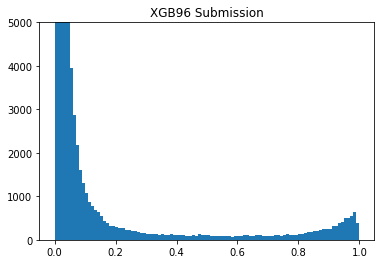

In [22]:
plt.hist(prediction["isFraud"],bins=100)
plt.ylim((0,5000))
plt.title('XGB96 Submission')
plt.show()

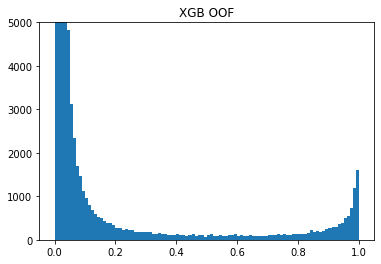

In [23]:
plt.hist(out_of_fold,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOF')
plt.show()

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
submission = pd.read_csv("../ieee_fraud_data/sample_submission.csv")
submission.isFraud = predictions
submission.to_csv("xgb_cv.csv", index=False)

### Find best hyperparameters for the model

In [ ]:
distributions = {
    "subsample": [0.2, 0.4, 0.6, 0.8],
    "max_depth": range(5, 13),
    "colsample_bytree": [0.2, 0.4, 0.6, 0.8]
}

X_train = pd.concat([X_train[X_train["Fold"] == index][:10000] for index in range(1, 7)])
y_train = y_train.loc[X_train.index]

In [ ]:
kfold = GroupKFold(n_splits=6)

model = xgb.XGBClassifier(         
        learning_rate=0.02,
        missing=-1, 
        eval_metric='auc',
)
grid_search = RandomizedSearchCV(model, distributions, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=10)
grid_result = grid_search.fit(X_train, y_train["isFraud"], groups=X_train["Fold"])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))